In [29]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import tensorflow as tf
tf.compat.v1.enable_eager_execution
from keras.models import Model, load_model
from keras.layers import Lambda, Input, Dense
from keras.losses import binary_crossentropy, kl_divergence
from keras.losses import MeanSquaredError as mse
from keras import optimizers

from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt


# Hello, this is Nikos :)

%matplotlib inline

In [2]:
urls = [
        "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz",
        "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names"
        ]

In [3]:
# this pre-processing code of the KDD dataset is adapter from https://github.com/lironber/GOAD/blob/master/data_loader.py

df_colnames = pd.read_csv(urls[1], skiprows=1, sep=':', names=['f_names', 'f_types'])
df_colnames.loc[df_colnames.shape[0]] = ['status', ' symbolic.']

df = pd.read_csv(urls[0], header=None, names=df_colnames['f_names'].values)
df_symbolic = df_colnames[df_colnames['f_types'].str.contains('symbolic.')]
df_continuous = df_colnames[df_colnames['f_types'].str.contains('continuous.')]
samples = pd.get_dummies(df.iloc[:, :-1], columns=df_symbolic['f_names'][:-1])

labels = np.where(df['status'] == 'normal.', 1, 0)

In [4]:
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,status
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.00,0.00,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494019,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


In [5]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(samples)

In [6]:
norm_samples = df_scaled[labels == 1]  # normal data
attack_samples = df_scaled[labels == 0]  # attack data

norm_labels = labels[labels == 1]
attack_labels = labels[labels == 0]

In [7]:
attack_samples.shape

(396743, 121)

In [8]:
# generate train set
# training set will consist of the normal ds

len_norm = len(norm_samples)
len_norm_train = int(0.8 * len_norm)
X_train = norm_samples[:len_norm_train]

# generate test set consist of 50% attack and 50% normal

X_test_norm = norm_samples[len_norm_train:]
len_attack_test = len(X_test_norm) # we will use the same number
X_test_attack = attack_samples[:len_attack_test]

X_test = np.concatenate([X_test_norm, X_test_attack])
y_test = np.ones(len(X_test))
y_test[:len(X_test_norm)] = 0

In [71]:
X_train.shape

(77822, 121)

In [72]:
X_test.shape

(38912, 121)

In [35]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [36]:
# The reparameterization trick

def sample(args):
    z_mean, z_log_var = args
    batch = tf.keras.backend.shape(z_mean)[0]
    dim = tf.keras.backend.int_shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

In [37]:
class VAELossLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        x, x_decoded_mean, z_mean, z_log_var = inputs
        # compute the average MSE error, then scale it up, i.e. simply sum on all axes
        reconstruction_loss = tf.reduce_sum(tf.square(x - x_decoded_mean))
        # compute the KL loss
        kl_loss = - 0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        # return the average loss over all 
        total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)    
        self.add_loss(total_loss)
        return x  # Dummy output

In [38]:
original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

In [39]:
print(input_shape)

(121,)


In [40]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  


 encoder_input (InputLayer)  [(None, 121)]                0         []                            
                                                                                                  
 dense_8 (Dense)             (None, 60)                   7320      ['encoder_input[0][0]']       
                                                                                                  
 z_mean (Dense)              (None, 40)                   2440      ['dense_8[0][0]']             
                                                                                                  
 z_log_var (Dense)           (None, 40)                   2440      ['dense_8[0][0]']             
                                                                                                  
 z (Lambda)                  (None, 40)                   0         ['z_mean[0][0]',              
                                                                     'z_log_var[0][0]']           
          

In [41]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 40)]              0         
                                                                 
 dense_9 (Dense)             (None, 60)                2460      
                                                                 
 dense_10 (Dense)            (None, 121)               7381      
                                                                 
Total params: 9841 (38.44 KB)
Trainable params: 9841 (38.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
# full VAE model
inputs = Input(shape=input_shape, name='encoder_input')

x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# Use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')

# Decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name='decoder')

outputs = decoder(encoder(inputs))
vae_loss_layer = VAELossLayer()([inputs, outputs, z_mean, z_log_var])

vae_model = Model(inputs, [outputs, vae_loss_layer], name='vae_mlp')

In [26]:
def comp_kl_loss(z_mean, z_log_var):
    loss= - 0.5 * tf.keras.backend.sum(1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.square(tf.keras.backend.exp(z_log_var)), axis=-1)
    return loss

In [32]:
# # the KL loss function:
# def vae_loss(x, x_decoded_mean):
#     # compute the average MSE error, then scale it up, ie. simply sum on all axes
#     reconstruction_loss = tf.keras.backend.sum(tf.keras.backend.square(x - x_decoded_mean))
#     # compute the KL loss
#     kl_loss = - 0.5 * tf.keras.backend.sum(1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.square(tf.keras.backend.exp(z_log_var)), axis=-1)
#     # return the average loss over all 
#     total_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)    
#     #total_loss = reconstruction_loss + kl_loss
#     return total_loss

def vae_loss(x, x_decoded_mean, z_mean, z_log_var):
    # compute the average MSE error, then scale it up, i.e. simply sum on all axes
    reconstruction_loss = tf.reduce_sum(tf.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.square(tf.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)    
    return total_loss

In [44]:
opt = optimizers.Adam(learning_rate=0.0001, clipvalue=0.5)
#opt = optimizers.RMSprop(learning_rate=0.0001)

vae_model.compile(optimizer=opt, loss=lambda y_true, y_pred: y_pred)
vae_model.summary()
# Finally, we train the model:
results = vae_model.fit(X_train, X_train,
                        shuffle=True,
                        epochs=32,
                        batch_size=256)

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 121)]                0         []                            
                                                                                                  
 encoder (Functional)        (None, 40)                   12200     ['encoder_input[0][0]']       
                                                                                                  
 dense_11 (Dense)            (None, 60)                   7320      ['encoder_input[0][0]']       
                                                                                                  
 decoder (Functional)        (None, 121)                  9841      ['encoder[0][0]']             
                                                                                            

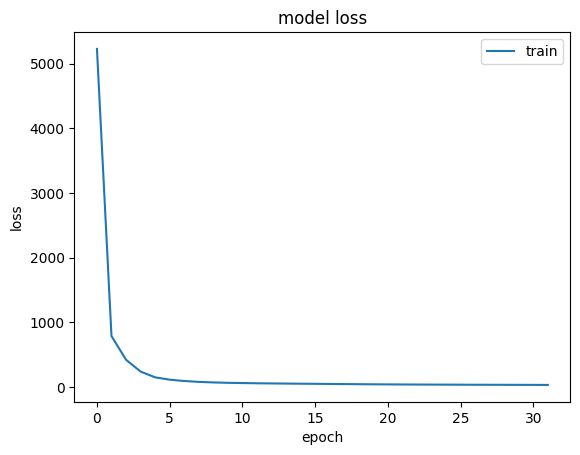

In [45]:
plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [76]:
X_train_pred = vae_model.predict(X_train)[0]

2432/2432 [==============================] - 4s 1ms/step


In [77]:
mae_vector = get_error_term(X_train_pred, X_train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)

Avg error 0.003332726432432193
median error 0.002343422783508389
99Q: 0.01807703099139806
setting threshold on 0.01807703099139806 


In [78]:
X_pred = vae_model.predict(X_test)[0]
mae_vector = get_error_term(X_pred, X_test, _rmse=False)
anomalies = (mae_vector > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)

1216/1216 [==============================] - 2s 2ms/step


0.45674856085526316

In [79]:
from sklearn.metrics import classification_report

print(classification_report(y_test, anomalies))

              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94     19456
         1.0       0.98      0.90      0.94     19456

    accuracy                           0.94     38912
   macro avg       0.94      0.94      0.94     38912
weighted avg       0.94      0.94      0.94     38912



In [80]:
X_pred.shape

(38912, 121)

In [81]:
X_encoded = encoder.predict(X_test)

1216/1216 [==============================] - 2s 1ms/step


In [82]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_transform = pca.fit_transform(X_encoded)

C:\Users\nickf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nickf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nickf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

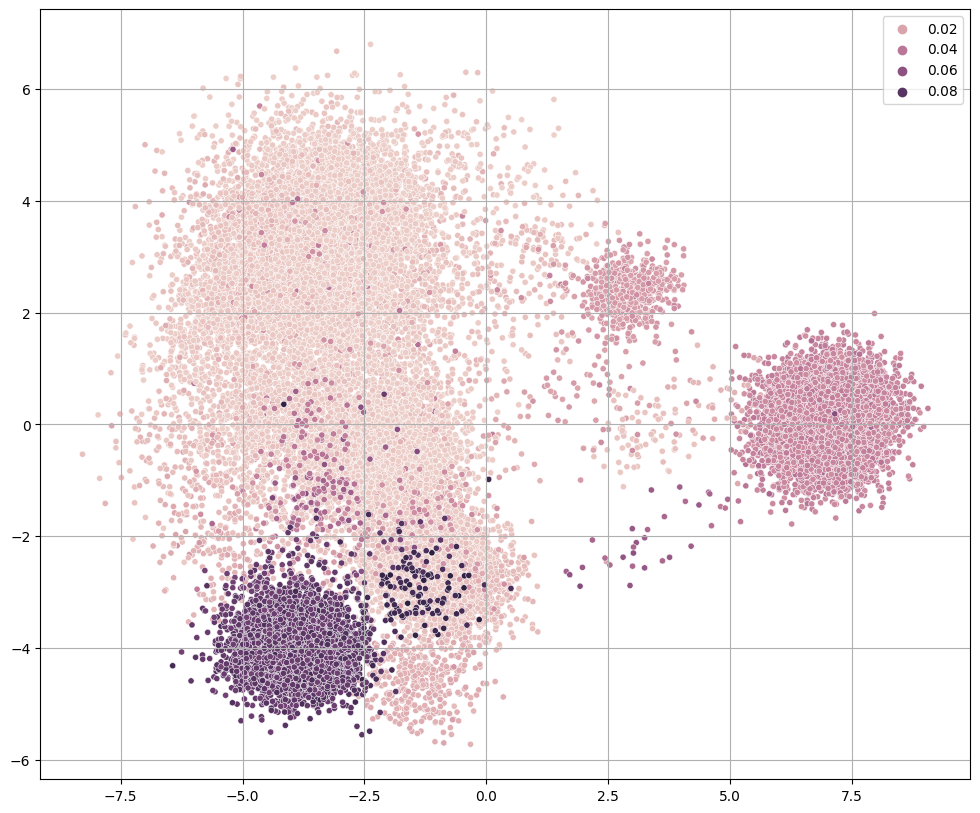

In [83]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector)
plt.grid()
plt.show()

C:\Users\nickf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nickf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nickf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

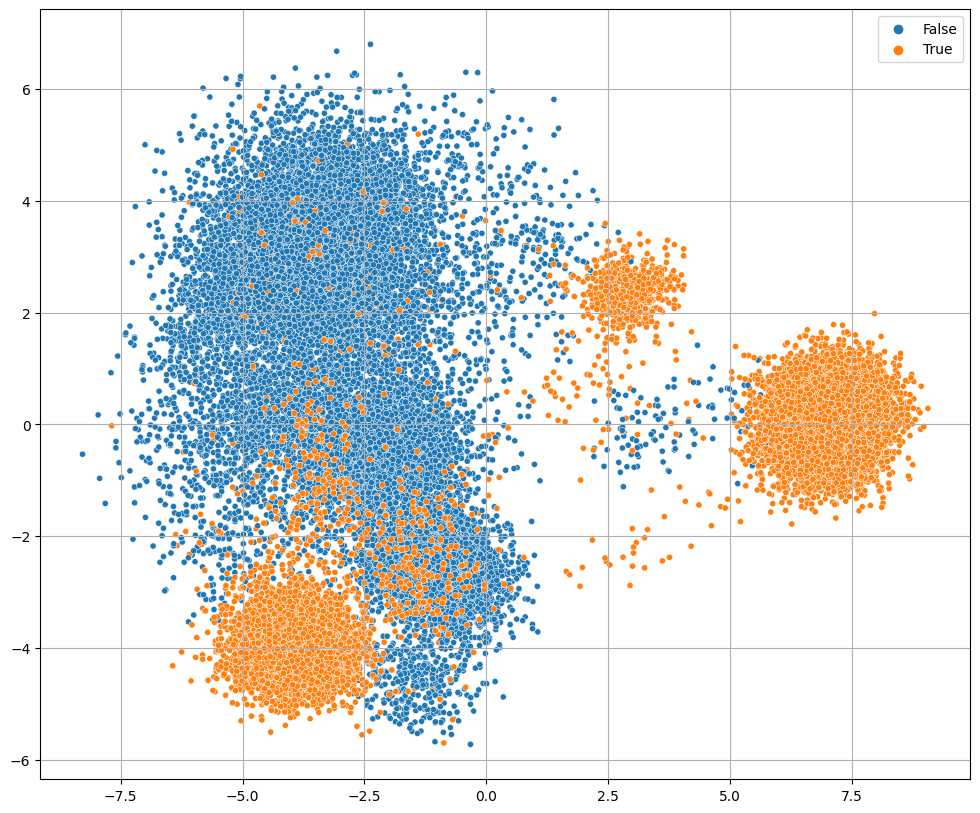

In [84]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies)
plt.grid()
plt.show()

C:\Users\nickf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nickf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nickf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

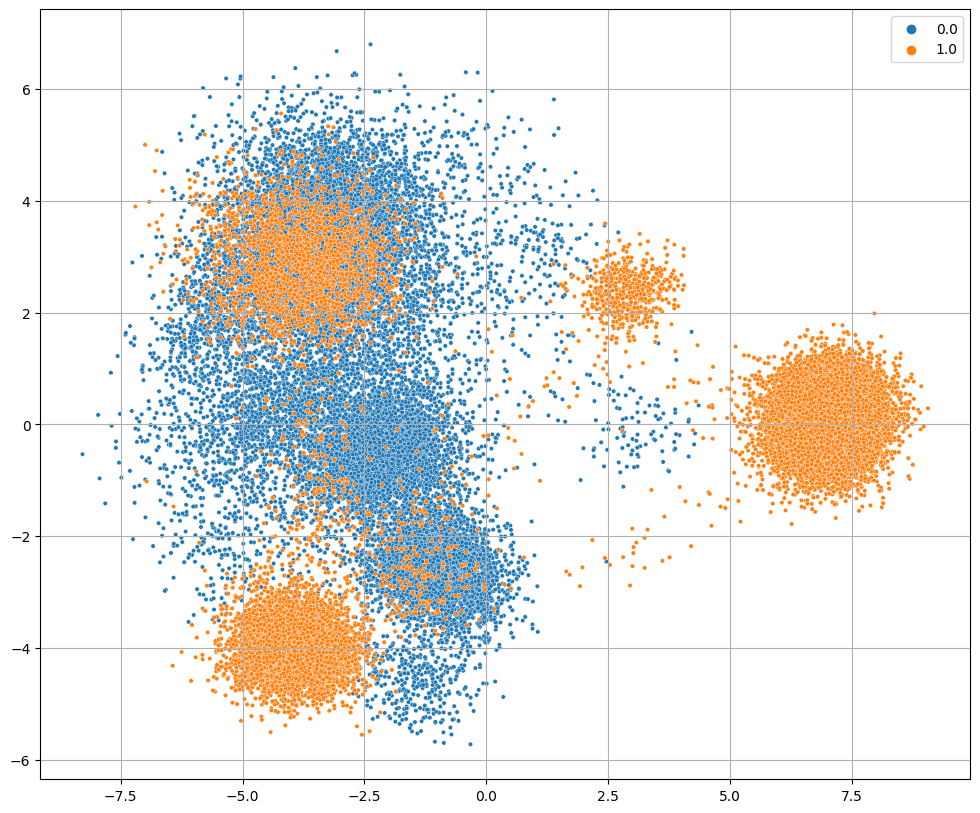

In [85]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test)
plt.grid()
plt.show()

In [90]:
from argparse import Namespace
from pathlib import Path
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import sklearn
from sklearn import preprocessing
import os

In [94]:
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# datafile_path = Path('/kaggle/input/nab/realKnownCause/realKnownCause/machine_temperature_system_failure.csv')
# datasets_root = Path('/kaggle/working')

In [95]:
raw_dt = pd.read_csv("data/realKnownCause/realKnownCause/machine_temperature_system_failure.csv")
# raw_dt = pd.read_csv(datafile_path)
raw_dt.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


In [96]:
raw_dt.describe()

,value
count,22695.000000
mean,85.926498
std,13.746912
min,2.084721
25%,83.080078
50%,89.408246
75%,94.016252
max,108.510543


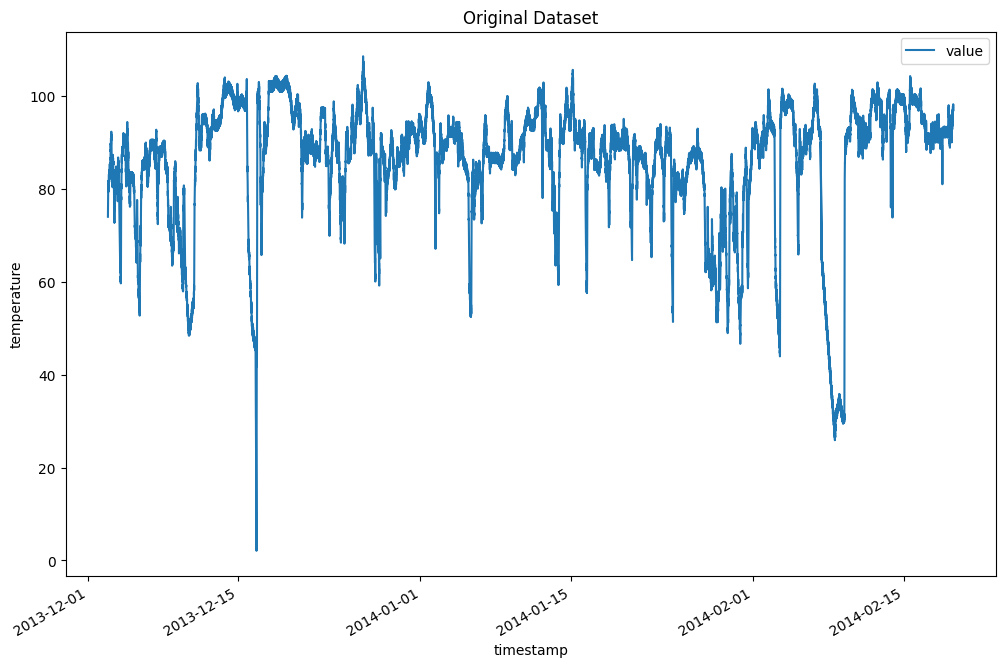

In [114]:
data = raw_dt.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.plot(x='timestamp', y='value', figsize=(12, 8))
plt.ylabel("temperature")
plt.title("Original Dataset");

In [115]:
data['timestamp'].min(), data['timestamp'].max()

(Timestamp('2013-12-02 21:15:00'), Timestamp('2014-02-19 15:25:00'))

In [116]:
data['day'] = data['timestamp'].dt.day
data['month'] = data['timestamp'].dt.month
data['hour_min'] = data['timestamp'].dt.hour + data['timestamp'].dt.minute / 60

data['day_of_week'] = data['timestamp'].dt.dayofweek
data['holiday'] = 0
data.loc[(data['day'] == 25) & (data['month'] == 12),'holiday'] = 1  # Christmas
data.loc[(data['day'] == 1) & (data['month'] == 1),'holiday'] = 1  # New Year's Day

In [117]:
holidays = data.loc[data['holiday'] == 1, 'timestamp'].dt.date.unique()
holidays

array([datetime.date(2013, 12, 25), datetime.date(2014, 1, 1)],
      dtype=object)

In [118]:
for i, hd in enumerate(holidays):
    data['hol_' + str(i)] = data['timestamp'].dt.date - hd

In [119]:
for i in range(data.shape[0]):
    if np.abs(data.loc[data.index[i], 'hol_0']) <= np.abs(data.loc[data.index[i], 'hol_1']):
        data.loc[data.index[i], 'gap_holiday'] = data.loc[data.index[i], 'hol_0']
    else:
        data.loc[data.index[i], 'gap_holiday'] = data.loc[data.index[i], 'hol_1']

In [120]:
data['gap_holiday'] = data['gap_holiday'].dt.days

In [121]:
data.drop(['hol_0', 'hol_1'], axis=1, inplace=True)

In [122]:
data['t'] = (data['timestamp'].astype(np.int64)/1e11).astype(np.int64)
data.drop('timestamp', axis=1, inplace=True)
data

,value,day,month,hour_min,day_of_week,holiday,gap_holiday,t
0,73.967322,2,12,21.250000,0,0,-23,13860189
1,74.935882,2,12,21.333333,0,0,-23,13860192
2,76.124162,2,12,21.416667,0,0,-23,13860195
3,78.140707,2,12,21.500000,0,0,-23,13860198
4,79.329836,2,12,21.583333,0,0,-23,13860201
...,...,...,...,...,...,...,...,...
22690,98.185415,19,2,15.083333,2,0,49,13928223
22691,97.804168,19,2,15.166667,2,0,49,13928226
22692,97.135468,19,2,15.250000,2,0,49,13928229
22693,98.056852,19,2,15.333333,2,0,49,13928232


In [123]:
cont_vars = ['value', 'hour_min', 'gap_holiday', 't']
cat_vars = ['day', 'month', 'day_of_week', 'holiday']

In [124]:
from sklearn.preprocessing import LabelEncoder

label_encoders = [LabelEncoder() for _ in cat_vars] 
for col, enc in zip(cat_vars, label_encoders):
    data[col] = enc.fit_transform(data[col])
    
data

,value,day,month,hour_min,day_of_week,holiday,gap_holiday,t
0,73.967322,1,2,21.250000,0,0,-23,13860189
1,74.935882,1,2,21.333333,0,0,-23,13860192
2,76.124162,1,2,21.416667,0,0,-23,13860195
3,78.140707,1,2,21.500000,0,0,-23,13860198
4,79.329836,1,2,21.583333,0,0,-23,13860201
...,...,...,...,...,...,...,...,...
22690,98.185415,18,1,15.083333,2,0,49,13928223
22691,97.804168,18,1,15.166667,2,0,49,13928226
22692,97.135468,18,1,15.250000,2,0,49,13928229
22693,98.056852,18,1,15.333333,2,0,49,13928232


In [125]:
test_ratio = 0.3
tr_data = data.iloc[: int(len(data) * (1 - test_ratio))]
tst_data = data.iloc[int(len(data) * (1 - test_ratio)) :]

In [126]:
scaler = preprocessing.StandardScaler().fit(tr_data[cont_vars])

In [127]:
tr_data_scaled = tr_data.copy()
tr_data_scaled[cont_vars] = scaler.transform(tr_data[cont_vars])
tst_data_scaled = tst_data.copy()
tst_data_scaled[cont_vars] = scaler.transform(tst_data[cont_vars])

In [128]:
tr_data, tr_data_scaled

(           value  day  month   hour_min  day_of_week  holiday  gap_holiday  \
 0      73.967322    1      2  21.250000            0        0          -23   
 1      74.935882    1      2  21.333333            0        0          -23   
 2      76.124162    1      2  21.416667            0        0          -23   
 3      78.140707    1      2  21.500000            0        0          -23   
 4      79.329836    1      2  21.583333            0        0          -23   
 ...          ...  ...    ...        ...          ...      ...          ...   
 15881  88.470506   25      0  23.666667            6        0           25   
 15882  88.395883   25      0  23.750000            6        0           25   
 15883  88.608302   25      0  23.833333            6        0           25   
 15884  87.756352   25      0  23.916667            6        0           25   
 15885  88.236311   26      0   0.000000            0        0           26   
 
               t  
 0      13860189  
 1      1386

In [129]:
tr_data_scaled.to_csv('data/train.csv', index=False)
tst_data_scaled.to_csv('data/test.csv', index=False)

In [130]:
tr_data_scaled

,value,day,month,hour_min,day_of_week,holiday,gap_holiday,t
0,-1.224398,1,2,1.336685,0,0,-1.866199,-1.732808
1,-1.134136,1,2,1.348691,0,0,-1.866199,-1.732590
2,-1.023399,1,2,1.360698,0,0,-1.866199,-1.732372
3,-0.835474,1,2,1.372704,0,0,-1.866199,-1.732153
4,-0.724658,1,2,1.384711,0,0,-1.866199,-1.731935
...,...,...,...,...,...,...,...,...
15881,0.127174,25,0,1.684873,6,0,1.825637,1.731208
15882,0.120220,25,0,1.696879,6,0,1.825637,1.731426
15883,0.140016,25,0,1.708885,6,0,1.825637,1.731644
15884,0.060621,25,0,1.720892,6,0,1.825637,1.731863


In [131]:
tst_data_scaled

,value,day,month,hour_min,day_of_week,holiday,gap_holiday,t
15886,0.128276,26,0,-1.712961,0,0,1.902550,1.732299
15887,-0.038872,26,0,-1.700954,0,0,1.902550,1.732517
15888,0.088313,26,0,-1.688948,0,0,1.902550,1.732736
15889,0.124557,26,0,-1.676941,0,0,1.902550,1.732954
15890,0.014094,26,0,-1.664935,0,0,1.902550,1.733172
...,...,...,...,...,...,...,...,...
22690,1.032520,18,1,0.448205,2,0,3.671554,3.217532
22691,0.996991,18,1,0.460212,2,0,3.671554,3.217751
22692,0.934674,18,1,0.472218,2,0,3.671554,3.217969
22693,1.020539,18,1,0.484225,2,0,3.671554,3.218187
